<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploration" data-toc-modified-id="Exploration-1">Exploration</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-1.1">Prepare data</a></span><ul class="toc-item"><li><span><a href="#Read-file" data-toc-modified-id="Read-file-1.1.1">Read file</a></span></li><li><span><a href="#Sample-data" data-toc-modified-id="Sample-data-1.1.2">Sample data</a></span></li><li><span><a href="#Change-columns" data-toc-modified-id="Change-columns-1.1.3">Change columns</a></span></li></ul></li><li><span><a href="#Coordinates" data-toc-modified-id="Coordinates-1.2">Coordinates</a></span></li><li><span><a href="#Datetime" data-toc-modified-id="Datetime-1.3">Datetime</a></span><ul class="toc-item"><li><span><a href="#Date-aggregation" data-toc-modified-id="Date-aggregation-1.3.1">Date aggregation</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.3.2">Outliers</a></span></li><li><span><a href="#Seasonal-decompose" data-toc-modified-id="Seasonal-decompose-1.3.3">Seasonal decompose</a></span></li></ul></li><li><span><a href="#Export-data" data-toc-modified-id="Export-data-1.4">Export data</a></span><ul class="toc-item"><li><span><a href="#Update-columns" data-toc-modified-id="Update-columns-1.4.1">Update columns</a></span></li><li><span><a href="#Remove-outliers" data-toc-modified-id="Remove-outliers-1.4.2">Remove outliers</a></span></li><li><span><a href="#Export-to-a-feather-file" data-toc-modified-id="Export-to-a-feather-file-1.4.3">Export to a feather file</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = (10, 7)

import pandas as pd
pd.set_option('max_columns', 40)
pd.set_option('max_rows', 20)
pd.set_option('precision', 3)

# Exploration

This notebook created to explore basic properties of the dataset, like plotting distributions, outlier detection, quick look at seasonality and trends in the data.

## Prepare data

The data is derived from NYC taxi dataset. The script for preprocessing is in the **data** folder.

### Read file

The data is stored in feather format (see [The Best Format to Save Pandas Data](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d))

In [2]:
%%time 

raw_data = pd.read_feather('../data/data.feather')

print(f'Dataset shape: {raw_data.shape}\n')
raw_data.head(3)

Dataset shape: (65783796, 8)

CPU times: user 2.51 s, sys: 9.06 s, total: 11.6 s
Wall time: 35.7 s


,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.511,-74.001,40.729,-74.010,40.720
1,2015-01-01 00:00:00,2015-01-01 00:11:26,5,6.437,-73.971,40.760,-73.921,40.768
2,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.543,-73.988,40.765,-73.977,40.777


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65783796 entries, 0 to 65783795
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pickup_datetime   datetime64[ns]
 1   dropoff_datetime  datetime64[ns]
 2   passenger_count   int64         
 3   distance          float64       
 4   pickup_lon        float64       
 5   pickup_lat        float64       
 6   dropoff_lon       float64       
 7   dropoff_lat       float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 3.9 GB


### Sample data

Memory usage: **3.9GB**. Let's take a sample to reduce the memory cosumption

In [4]:
%%time

def sample_data(data: pd.DataFrame, sample_size) -> pd.DataFrame:
    if data.shape[0] > sample_size:
        data = data.sample(sample_size)
        
    return data.reset_index(drop=True)

seed = 234
np.random.seed(seed)

sample_size = 1000000

data = sample_data(raw_data, sample_size)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   pickup_datetime   1000000 non-null  datetime64[ns]
 1   dropoff_datetime  1000000 non-null  datetime64[ns]
 2   passenger_count   1000000 non-null  int64         
 3   distance          1000000 non-null  float64       
 4   pickup_lon        1000000 non-null  float64       
 5   pickup_lat        1000000 non-null  float64       
 6   dropoff_lon       1000000 non-null  float64       
 7   dropoff_lat       1000000 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 61.0 MB
CPU times: user 4.4 s, sys: 5.88 s, total: 10.3 s
Wall time: 11.6 s


### Change columns

In this exercise we are interested only in pickup locations and pickup time so we can drop other columns.

In [5]:
def update_columns(data: pd.DataFrame) -> None:
    """
    Drop columns that are not used in this research and rename remaining
    """
    
    drop_columns = [
        'dropoff_datetime',
        'passenger_count',
        'distance',    
        'dropoff_lon',
        'dropoff_lat'
    ]
    
    rename_columns = {
        'pickup_datetime': 'datetime',
        'pickup_lat': 'lat',
        'pickup_lon': 'lon'
    }
    
    # drop only of columns are still in the dataset
    if drop_columns[0] in data.columns:
        data = data.drop(drop_columns, axis=1)

    return data.rename(columns=rename_columns)

data = update_columns(data)

data.head(3)

,datetime,lon,lat
0,2015-02-03 06:53:45,-73.977,40.749
1,2015-01-28 06:51:39,-73.976,40.748
2,2015-06-26 08:35:58,-73.976,40.792


## Coordinates

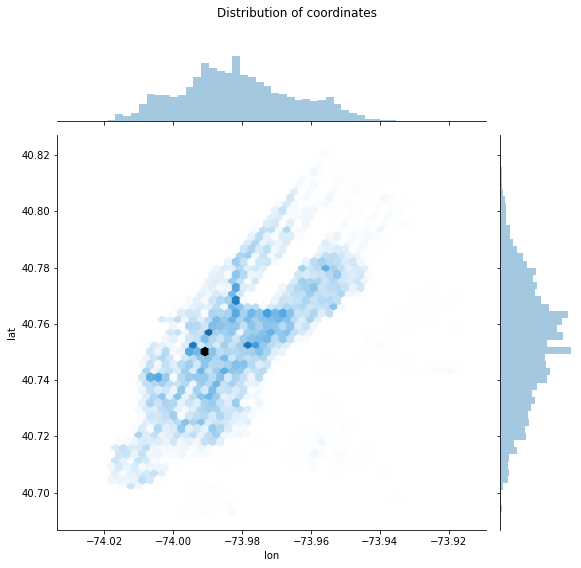

In [6]:
sns.jointplot(data=data, x='lon', y='lat', kind='hex', height=8)

plt.suptitle('Distribution of coordinates')
plt.subplots_adjust(top=.9);

## Datetime

###  Date aggregation

Aggregate pickups per day

In [7]:
date_agg_data = data.groupby(data.datetime.dt.date).datetime.size()
date_agg_data = date_agg_data.to_frame('total')

date_agg_data.head(3)

,total
datetime,
2015-01-01,4661
2015-01-02,4586
2015-01-03,5250


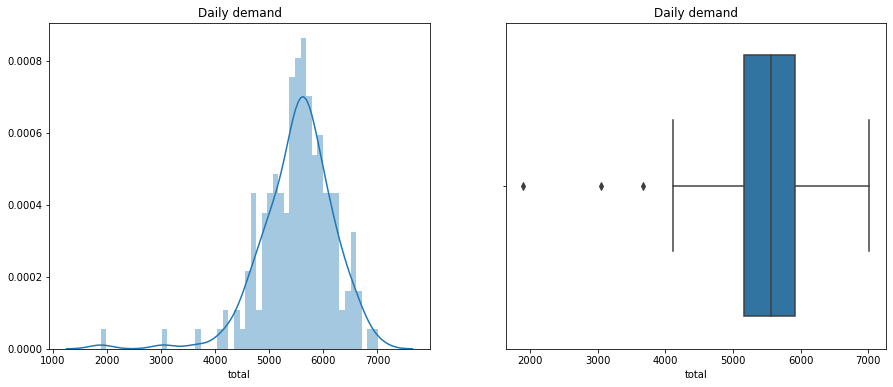

In [8]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.title('Daily demand')
sns.distplot(date_agg_data.total, bins=50)

plt.subplot(122)
plt.title('Daily demand')
sns.boxplot(date_agg_data.total);

### Outliers

Instead of standard deviation method to detect outliers we can use robust method based on median absolute deviation ( _Page 19, [Data Cleaning](https://www.goodreads.com/book/show/50193945-data-cleaning), 2019_ ):

> ... the median and the median absolute deviation (MAD) that can replace mean and standard deviation, respectively.

> The median and MAD lead to a robust outlier detection technique known as Hampel X84 that is quite reliable in the face of outliers since it has a breakdown point of 50%. Hampel X84 marks outliers as those data points that are more than 1.4826θ MADs away from the median, where θ is the number of standard deviations away from the mean one would have used if there were no outliers in the dataset. The constant 1.4826 is derived under a normal distribution, where one standard deviation away from the mean is about 1.4826 MADs.

In [9]:
def MAD_outliers(data: pd.Series) -> pd.Series:
    """Detect outliers use MAD based method and return a binary index"""
    num_std = 3
    theta = 1.4826
    
    median = data.median()
    mad = np.median((data - median).abs())
    
    lower = median - mad * (theta * num_std)
    upper = median + mad * (theta * num_std)

    return ((data < lower) | (data > upper))

index_outliers = MAD_outliers(date_agg_data.total)
date_agg_data[index_outliers]

,total
datetime,
2015-01-26,3047
2015-01-27,1892
2015-05-25,3672


There are 3 outliers. Some special events happened on each of those days:

- 2015-01-26: [January 2015 North American blizzard](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard)
- 2015-01-27: [January 2015 North American blizzard](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard)
- 2015-05-25: [Memorial Day](https://www.vercalendario.info/en/event/united_states-holidays-25-may-2015.html)

### Seasonal decompose

Decompose weekly demand into trend and seasonal patterns without outliers

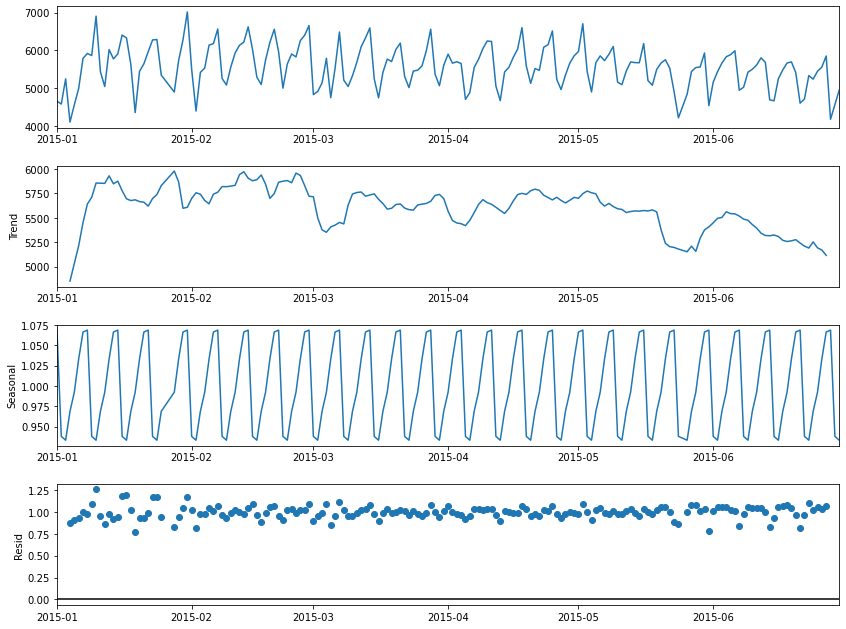

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

period = 7
model = 'multiplicative'

result = seasonal_decompose(date_agg_data[~index_outliers],
                            model=model,
                            period=period)

fig = result.plot()
fig.set_figheight(9)
fig.set_figwidth(12)

## Export data

### Update columns

In [11]:
data_to_save = update_columns(raw_data)

data_to_save

,datetime,lon,lat
0,2015-01-01 00:00:00,-74.001,40.729
1,2015-01-01 00:00:00,-73.971,40.760
2,2015-01-01 00:00:03,-73.988,40.765
3,2015-01-01 00:00:03,-73.969,40.754
4,2015-01-01 00:00:04,-73.957,40.775
...,...,...,...
65783791,2015-06-30 23:59:59,-73.975,40.761
65783792,2015-06-30 23:59:59,-73.976,40.756
65783793,2015-06-30 23:59:59,-73.994,40.719
65783794,2015-06-30 23:59:59,-73.984,40.729


### Remove outliers

In [12]:
idx = data_to_save.datetime.dt.date.isin(
    date_agg_data[index_outliers].index.values)

data_to_save = data_to_save[~idx].reset_index(drop=True)

### Export to a feather file

File name is **structured_data.feather**

In [15]:
# name dataset using notebook id
file_name = 'data_01_00.feather'

data_to_save.to_feather(file_name)